In [1]:
# Import modules

import time 
import pandas as pd  
from lightkurve import search_targetpixelfile
from astropy.wcs import WCS
import matplotlib.pyplot as plt
from astropy.io import fits 
import numpy as np
from astroquery.gaia import Gaia
from astropy.coordinates import SkyCoord
import astropy.units as u
import math
from ast import literal_eval
import ssl
import lightkurve
import os
import glob


try:
     _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    # Legacy Python that doesn't verify HTTPS certificates by default,
    pass
else:
    # Handle target environment that doesn't support HTTPS verification,
    ssl._create_default_https_context = _create_unverified_https_context

# Paths and files 
code_file_path = r"C:\Users\User\Desktop\FluxCT\FluxCT_AutoClean\batch_code\example_code_and_plots/"
plot_path = r"C:\Users\User\Desktop\FluxCT\FluxCT_AutoClean\batch_code\example_code_and_plots/"
identifiers = pd.read_csv(code_file_path + 'test_tic_list.csv') # USER INPUT - TESS ID list  


tess_list = []
gaia_source_list = []
ra_list = []
dec_list = []
g_mag_list = []
ruwe_list = []
flux_list = []
not_found = []
a = 0

download_tasoc=r"C:\Users\User\Desktop\FluxCT\FluxCT_AutoClean\TASOC2\."   # Downloading Path for FITS file from TASOC

inputs = "TIC 25063656" # For testing purposes

tess = inputs[4:] # Getting the number ID

print('\n********** TESS ' + str(tess) + ' – Star Number ' + str(a) + ' **********') 



********** TESS 25063656 – Star Number 0 **********


In [2]:
if inputs[:3] == 'KIC':
    tpf = search_targetpixelfile(inputs, author='Kepler').download()

elif inputs[:3] == 'TIC':
    tpf = search_targetpixelfile(inputs, author='SPOC').download() # Try to download from SPOC first.
    if tpf !=None:
        print(f"Found Star {inputs} in SPOC")
        tpf_one = tpf[0]
        tpf_one.to_fits(plot_path + 'tess_' + str(tess) + '_fits.fits',overwrite=True)
        ap = tpf_one.pipeline_mask
    if tpf ==None: # SPOC search Failed. Try to doanload from TASOC.
        print("SPOC Failed. Switching to TASOC...")
        
        # Aperture Mask for TASOC 
        sr = lightkurve.search_lightcurve(inputs, author="tasoc")
        sr1 = sr[::2]  # each target has both a "CBV" and "ENS" light curve for each sector. 
                            # The TPF and aperture are the same for both, so you only need one.
        download_dir=download_tasoc   # Downloading Path for FITS file from TASOC

        # Find the first subdirectory in the download directory
        subdirectories = [d for d in os.listdir(download_dir) if os.path.isdir(os.path.join(download_dir, d))]
        subdirectories.sort()  # Sort to get a consistent order
        if subdirectories:
            first_subdir = os.path.join(download_dir, subdirectories[0])

            # Find the first FITS file in the first subdirectory
            fits_files = glob.glob(os.path.join(first_subdir, '**', '*.fits'), recursive=True)
            fits_files.sort()  # Sort to get a consistent order

            if fits_files:
                first_fits_file = fits_files[0]

                # Open the FITS file
                tess_test = fits.open(first_fits_file)

                # Getting Aperture Mask 
                tasoc_ap = tess_test[3].data
                ap = (tasoc_ap & 2).astype(bool)
                ap_size = len(ap)

                # Remember to close the file when done
                tess_test.close()

        tpf = lightkurve.search_tesscut(inputs).download(cutout_size=ap_size)
else:
    print('Warning!!! Searching Failed. Star Not Found in Kepler/SPOC/TASOC')

Found Star TIC 25063656 in SPOC


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightkurve\search.py:423: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


In [3]:
tpf_one = tpf[0]
tpf_one.to_fits(plot_path + 'tess_' + str(tess) + '_fits.fits',overwrite=True)

# Finding tpa
array = ap
print("pipe line mask array is",array)

# Finding the count of each pixel in the rows and columns of the mask. 
row_count = np.count_nonzero(array, axis=1)
col_count = np.count_nonzero(array, axis=0) 

# Columns = col are counting the x coordinate from left to right. 
# This is the lower limit in pixel number for the left hand side of the array
# By adding 1 to the result I am removing the index to 0.
count_x = 0
if col_count[0] != 0:
    count_x = 0
else:
    for i in range(len(col_count)):
        if col_count[i] == 0:
            count_x = i
        else:
            count_x = count_x + 1
            break
    
# Rows are counting the y coordinate from bottom to top.
# This is the lower limit in pixel number for the bottom of the array
# By adding 1 to the result I am removing the index to 0.
count_y = 0
if row_count[0] != 0:
    count_y = 0
else:
    for j in range(len(row_count)):
        if row_count[j] == 0:
            count_y = j 
        else:
            count_y = count_y + 1
            break

# Finding the top right pixel
array_2  = array[np.ix_(~np.all(array == False, axis=1), ~np.all(array == False, axis=0))]
tr_y = array_2.shape[0]  
tr_x = array_2.shape[1]  

# Top left pixel position 
tl_x = count_x - 0.5
tl_y = count_y + tr_y - 1 + 0.5

# Bottom right pixel position 
br_x = count_x + tr_x - 1 + 0.5
br_y = count_y - 0.5

# Bottom left pixel position
# Starts from the first pixel with a non-zero value so only include count_x and count_y 
bl_x = count_x - 0.5
bl_y = count_y - 0.5

# Top right pixel position
# Already calaculated these so just add the 0.5
tr_x = count_x + tr_x - 1 + 0.5
tr_y = count_y + tr_y - 1 + 0.5 

# Pulling image to plot
tpf_data = fits.open(plot_path + 'tess_' + str(tess) + '_fits.fits')
image = tpf_data[1].data
image = image['FLUX'][0]
wcs = WCS(tpf_data[2].header)

# Finding the corners of the aperture mask
tl = tpf_one.wcs.pixel_to_world(tl_x, tl_y)
tr = tpf_one.wcs.pixel_to_world(tr_x, tr_y)
bl = tpf_one.wcs.pixel_to_world(bl_x, bl_y)
br = tpf_one.wcs.pixel_to_world(br_x, br_y)

# Converting the corners of the aperture mask to coordinates for Gaia
top_left = wcs.world_to_pixel(tl)
top_right = wcs.world_to_pixel(tr)
bottom_left = wcs.world_to_pixel(bl)
bottom_right = wcs.world_to_pixel(br)

# Coordinates to search in Gaia 
tr_ra = tr.ra.deg
tr_dec = tr.dec.deg
tl_ra = tl.ra.deg
tl_dec = tl.dec.deg
br_ra = br.ra.deg
br_dec = br.dec.deg
bl_ra = bl.ra.deg
bl_dec = bl.dec.deg

# Creating Gaia call
polygon = str(br_ra) + ', ' + str(br_dec) + ', ' + str(bl_ra) + ', ' + str(bl_dec) + ', ' + str(tl_ra) + ', ' + str(tl_dec) + ', ' + str(tr_ra) + ', ' + str(tr_dec)
columns = 'source_id, ra, dec, phot_g_mean_mag, ruwe, phot_g_mean_flux'
polygon_top10query_base = """SELECT
{columns}
FROM gaiaedr3.gaia_source
WHERE 1=CONTAINS(
        POINT(ra, dec), 
        POLYGON({polygon}))
"""

# Querying Gaia
polygon_top10query = polygon_top10query_base.format(columns=columns, 
                        polygon=polygon)

polygon_top10query_job = Gaia.launch_job_async(polygon_top10query)

polygon_top10query_results = polygon_top10query_job.get_results()

pipe line mask array is [[False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False  True  True  True False False False False]
 [False False False False  True  True  True False False False False]
 [False False False False  True  True  True False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]
 [False False False False False False False False False False False]]
INFO: Query finished. [astroquery.utils.tap.core]


In [4]:
# Pulling data from Gaia
plot_source = list(polygon_top10query_results['source_id'])
plot_ra = list(polygon_top10query_results['ra'])
plot_dec = list(polygon_top10query_results['dec'])
phot = list(polygon_top10query_results['phot_g_mean_mag'])
ruwe = list(polygon_top10query_results['ruwe']) 
flux = list(polygon_top10query_results['phot_g_mean_flux']) 

# Pulling data from Gaia
plot_source = list(polygon_top10query_results['source_id'])
plot_ra = list(polygon_top10query_results['ra'])
plot_dec = list(polygon_top10query_results['dec'])
phot = list(polygon_top10query_results['phot_g_mean_mag'])
ruwe = list(polygon_top10query_results['ruwe']) 
flux = list(polygon_top10query_results['phot_g_mean_flux']) 

# Initializing lists
plot_source_order = []
plot_ra_order = []
plot_dec_order = []
plot_ruwe_order = []
plot_phot_order = np.sort(phot)
plot_flux_order = []

# Putting the data in the correct order for plotting
for i in range(len(phot)):
    if plot_phot_order[i] in phot:
        index = phot.index(plot_phot_order[i])
        plot_source_order.append(plot_source[index]) 
        plot_ra_order.append(plot_ra[index])
        plot_dec_order.append(plot_dec[index])
        plot_ruwe_order.append(ruwe[index]) 
        plot_flux_order.append(flux[index]) 

# Saving final data lists for the output file
tess_list.append(tess)
ra_list.append(plot_ra_order) 
dec_list.append(plot_dec_order) 
gaia_source_list.append(plot_source_order) 
ruwe_list.append(plot_ruwe_order) 
flux_list.append(plot_flux_order) 


companians is <SkyCoord (ICRS): (ra, dec) in deg
    [(59.95329   , -70.07223558), (59.94063852, -70.08015276),
     (59.92671279, -70.07523943)]>


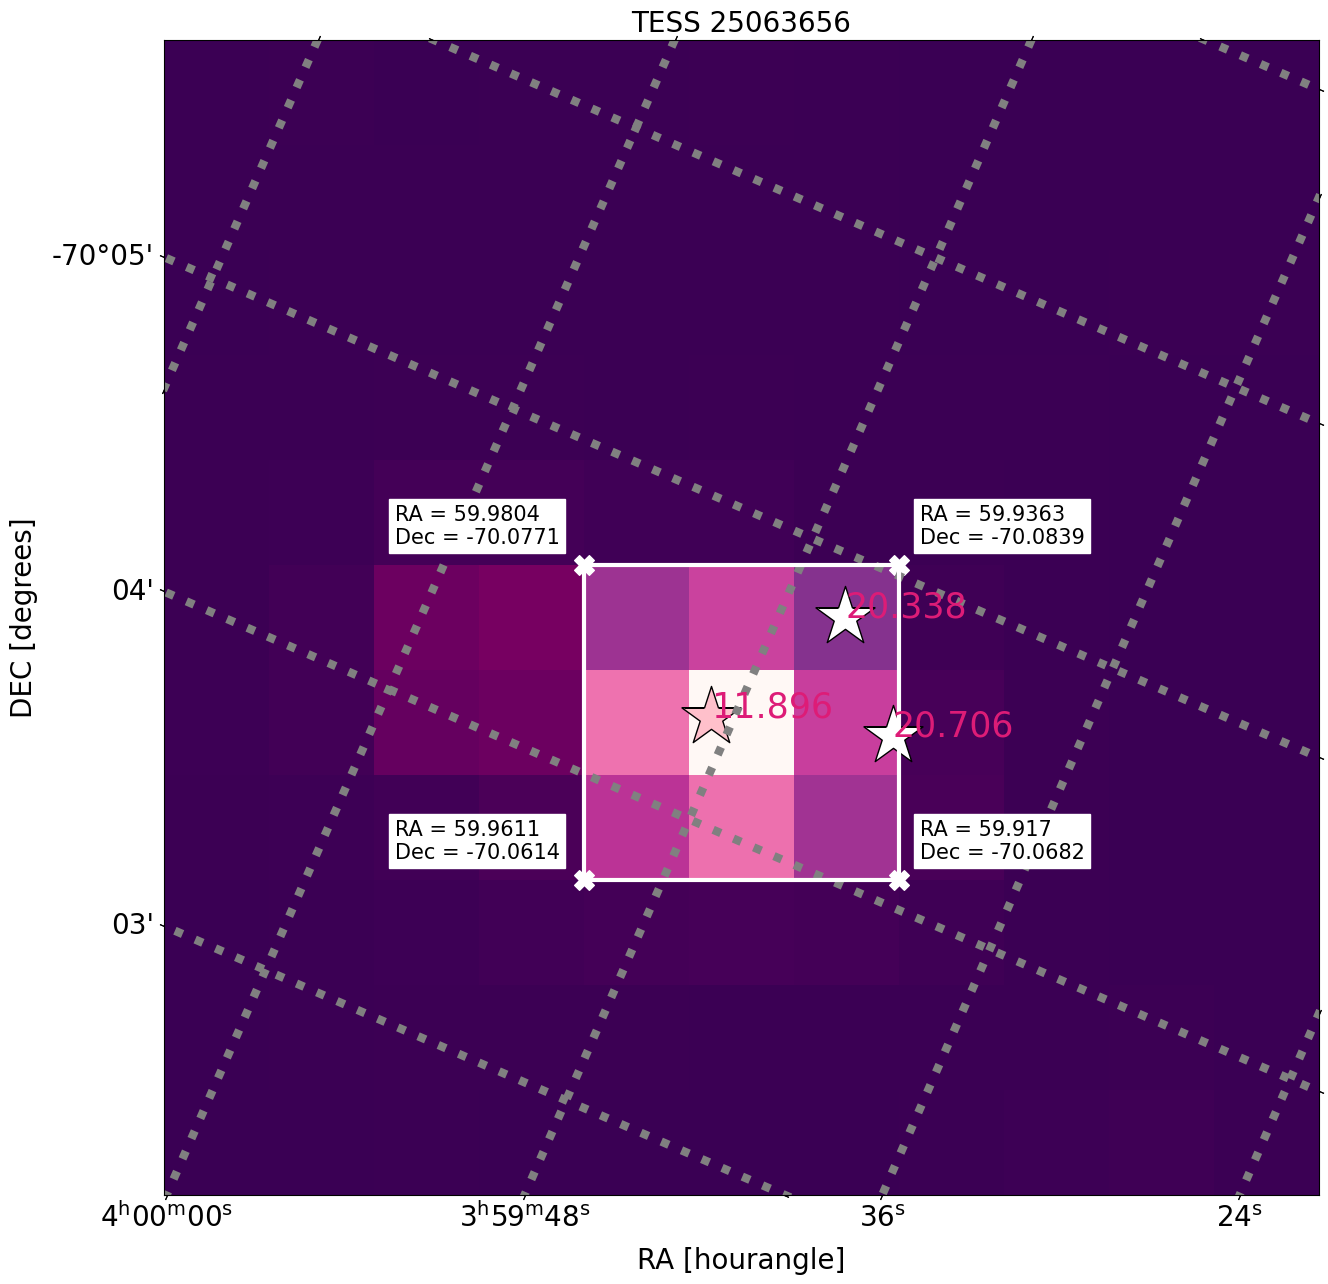

<Figure size 640x480 with 0 Axes>

In [5]:

# Removing nans from the photometry
plot_phot_order = [-999 if math.isnan(x) else x for x in plot_phot_order]
g_mag_list.append(plot_phot_order) 

# Determining the coordinates of the companions for plotting
companions = SkyCoord(plot_ra_order, plot_dec_order, unit='deg')
print("companians is",companions)
companions_to_plot = wcs.world_to_pixel(companions)

# Making beautiful plot! 
if len(companions_to_plot[0]) == 0: 
    print("Companions_to_plot is Empty!")
    not_found.append(tess) 
else: 

    # Setting figure
    fig = plt.figure(figsize=(18, 15))
    fig.add_subplot(111, projection = wcs) 

    # Plotting corners and box around TPA 
    top_line_x = [tl_x, tr_x]
    top_line_y = [tl_y, tr_y]
    plt.plot(top_line_x, top_line_y, linewidth=3, color='white')
    bottom_line_x = [bl_x, br_x]
    bottom_line_y = [bl_y, br_y]
    plt.plot(bottom_line_x, bottom_line_y, linewidth=3, color='white')
    left_line_x = [bl_x, tl_x]
    left_line_y = [bl_y, tl_y]
    plt.plot(left_line_x, left_line_y, linewidth=3, color='white')
    right_line_x = [br_x, tr_x]
    right_line_y = [br_y, tr_y]
    plt.plot(right_line_x, right_line_y, linewidth=3, color='white')

    # Plotting magnitudes 
    for i in range(len(phot)):
        try:
            plt.text(companions_to_plot[0][i], companions_to_plot[1][i], str(round(plot_phot_order[i], 3)), color='#dd1c77', fontsize=25)
        except:
            continue

    # Plotting target star and companions
    plt.scatter(companions_to_plot[0][1:], companions_to_plot[1][1:], marker='*', s=2000, color='white', edgecolor='black')
    plt.scatter(companions_to_plot[0][0], companions_to_plot[1][0], marker='*', s=2000, color='pink', edgecolor='black')
    
    # Plotting corner text 
    plt.text(tr_x+0.2, tr_y+0.2, 'RA = ' + str(round(tr.ra.deg, 4)) + '\nDec = ' + str(round(tr.dec.deg, 4)), fontsize=15, backgroundcolor='white') 
    plt.text(tl_x-1.8, tl_y+0.2, 'RA = ' + str(round(tl.ra.deg, 4)) + '\nDec = ' + str(round(tl.dec.deg, 4)), fontsize=15, backgroundcolor='white') 
    plt.text(br_x+0.2, br_y+0.2, 'RA = ' + str(round(br.ra.deg, 4)) + '\nDec = ' + str(round(br.dec.deg, 4)), fontsize=15, backgroundcolor='white') 
    plt.text(bl_x-1.8, bl_y+0.2, 'RA = ' + str(round(bl.ra.deg, 4)) + '\nDec = ' + str(round(bl.dec.deg, 4)), fontsize=15, backgroundcolor='white') 
    
    # Plotting corners
    plt.scatter(tr_x, tr_y, s=200, marker='X', color='white') # Top right
    plt.scatter(tl_x, tl_y, s=200, marker='X', color='white') # Top left
    plt.scatter(br_x, br_y, s=200, marker='X', color='white') # Bottom right
    plt.scatter(bl_x, bl_y, s=200, marker='X', color='white') # Bottom left

    # Setting axes for ticks
    ax = plt.gca()

    # Plotting axes labels, titles, and images
    plt.ylabel('DEC [degrees]', fontsize=20)
    plt.xlabel('RA [hourangle]', fontsize=20)
    plt.imshow(image, origin='lower', cmap='RdPu_r', alpha=1)
    plt.imshow(array, origin='lower',  cmap='binary_r', alpha=0.2)
    plt.title('TESS ' + str(tess), fontsize=20)

    # Setting tick parameters 
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)

    # Plotting grid and saving the file
    plt.grid(axis = 'both', color='grey', ls = ':', linewidth=6)
    plt.show()
    plt.savefig(plot_path + str(tess) + 'new.png')
    a = a + 1
    tpf_data.close()
    plt.savefig(f"{inputs}.jpg")
    